In [ ]:
from datasets import load_dataset
from huggingface_hub import notebook_login
import os
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO

# notebook_login()

### Dataset

In [2]:
ds = load_dataset("tech4humans/signature-detection")

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1980
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 420
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 419
    })
})

In [4]:
ds['train'][0]['objects']

{'id': [2134, 2135, 2136, 2137],
 'area': [5081, 1064, 4626, 1503],
 'bbox': [[198.0, 55.0, 43.060001373291016, 118.0],
  [263.0, 195.0, 24.750999450683594, 43.0],
  [518.0, 37.0, 46.72800064086914, 99.0],
  [587.0, 157.0, 28.908000946044922, 52.0]],
 'category': [0, 0, 0, 0]}

In [5]:
def convert_to_YOLO_format(objects, image_width, image_height):
    result = []
    for bbox, category in zip(objects['bbox'], objects['category']):
        x_min, y_min, w, h = bbox
        x_center = (x_min + w / 2) / image_width
        y_center = (y_min + h / 2) / image_height
        w_norm = w / image_width
        h_norm = h / image_height
        
        YOLO_format = f"{category} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}"
        result.append(YOLO_format)
        
    return '\n'.join(result)
    

def convert_dataset_to_YOLO_format(ds):
    """
    Convert the dataset to YOLO format.
    """
    for split in ds.keys():
        # Create the directory for the split
        os.makedirs(f"data/{split}/images", exist_ok=True)
        os.makedirs(f"data/{split}/labels", exist_ok=True)

        # Save images and labels
        for image_id, image, width, height, objects in zip(
            ds[split]["image_id"], ds[split]["image"], ds[split]["width"], ds[split]["height"], ds[split]["objects"]):
    
            # Save image
            image.save(f"data/{split}/images/{image_id}.jpg")

            label = convert_to_YOLO_format(objects, width, height)
            
            # Save label
            with open(f"data/{split}/labels/{image_id}.txt", "w") as f:
                f.write(label)

In [6]:
# convert_dataset_to_YOLO_format(ds)

In [7]:
def visualize_YOLO_format(image, labels):
    image = image.convert("RGB")
    width, height = image.size

    for bbox in labels:
        # Unnormalize and convert YOLO format to (x_min, y_min, x_max, y_max)
        if len(bbox) == 5:
            category, x_center, y_center, w_norm, h_norm = bbox
        elif len(bbox) == 4:
            x_center, y_center, w_norm, h_norm = bbox
        x_min = (x_center - w_norm / 2) * width
        y_min = (y_center - h_norm / 2) * height
        w = w_norm * width
        h = h_norm * height
        x_max = x_min + w
        y_max = y_min + h
        
        # Draw the bounding box
        draw = ImageDraw.Draw(image)
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)

    return image

def load_image_data(split, image_id):
    
    image_path = f"data/{split}/images/{image_id}.jpg" 
    image = Image.open(image_path)

    with open(f"data/{split}/labels/{image_id}.txt", "r") as f:
        labels = f.readlines()
        labels = [label.strip('\n').split(' ') for label in labels]
        labels = [(int(label[0]), float(label[1]), float(label[2]), float(label[3]), float(label[4])) for label in labels]
        
    return image, labels
    

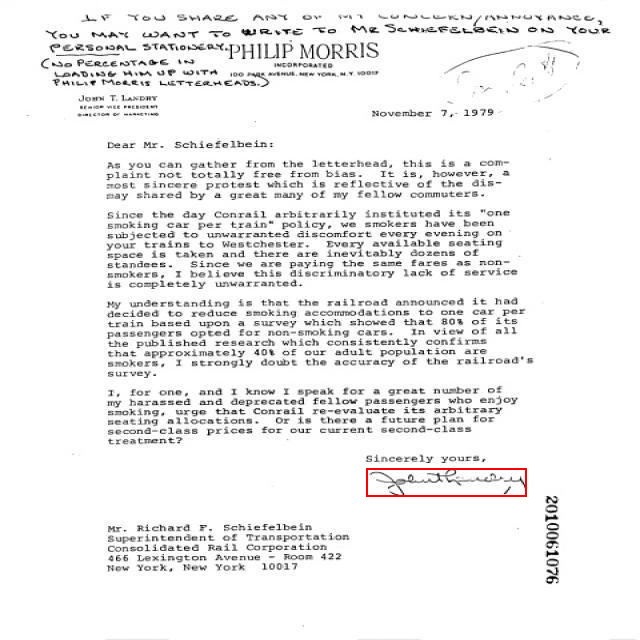

In [8]:
image , labels = load_image_data("train",0)
visualize_YOLO_format(image, labels)

### YOLO Model

In [ ]:
# from ultralytics import YOLO

# Load a pretrained YOLO model (recommended for training)
# model = YOLO("yolo11n.pt")
# model.to('cpu')


# model.train(data="Data.yaml", epochs=1) 

# Evaluate the model's performance on the validation set
# results = model.val()

# # Perform object detection on an image using the model
# results = model("https://ultralytics.com/images/bus.jpg")

# # Export the model to ONNX format
# success = model.export(format="onnx")

engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=Data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, 

train: Scanning C:\Users\wassi\Desktop\CareCare-OCR\Local_Dev\YOLO\data\train\labels.cache... 1980 images, 180 backgrounds, 0 corrupt: 100%|██████████| 1980/1980 [00:00<?, ?it/s]
val: Scanning C:\Users\wassi\Desktop\CareCare-OCR\Local_Dev\YOLO\data\validation\labels.cache... 420 images, 44 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<?, ?it/s]

Plotting labels to runs\detect\train2\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train2
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      1.965      3.102      1.565         31        640: 100%|██████████| 124/124 [27:53<00:00, 13.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [02:14<00:00,  9.62s/it]


                   all        420        455       0.53      0.473       0.47      0.142

1 epochs completed in 0.506 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 5.5MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.104  Python-3.12.6 torch-2.6.0+cu126 CPU (Intel Core(TM) i3-8145U 2.10GHz)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [01:34<00:00,  6.76s/it]


                   all        420        455      0.522      0.479      0.474      0.142
Speed: 3.2ms preprocess, 200.3ms inference, 0.0ms loss, 11.2ms postprocess per image
Results saved to runs\detect\train2
Ultralytics 8.3.104  Python-3.12.6 torch-2.6.0+cu126 CPU (Intel Core(TM) i3-8145U 2.10GHz)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\Users\wassi\Desktop\CareCare-OCR\Local_Dev\YOLO\data\validation\labels.cache... 420 images, 44 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [01:20<00:00,  3.00s/it]


                   all        420        455      0.522      0.479      0.474      0.142
Speed: 2.5ms preprocess, 169.5ms inference, 0.0ms loss, 10.2ms postprocess per image
Results saved to runs\detect\train22


In [32]:
model_path = 'runs/detect/train2/weights/best.pt'
model = YOLO(model_path)
model.to("cpu")

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [37]:
def model_predict(image_path):
    """
    Perform object detection on an image using the YOLO model.
    """
    results = model(image_path)
    return results[0].boxes.xywhn.cpu().tolist()

def model_predict_and_visualize(image_path):
    """
    Perform object detection on an image and visualize the results.
    """
    image = Image.open(image_path)
    labels = model_predict(image_path)
    
    image = visualize_YOLO_format(image, labels)
    
    return image, labels

model_predict_and_visualize("data/test/images/2.jpg")

    


image 1/1 c:\Users\wassi\Desktop\CareCare-OCR\Local_Dev\YOLO\data\test\images\2.jpg: 640x640 (no detections), 246.3ms
Speed: 5.3ms preprocess, 246.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


(<PIL.Image.Image image mode=RGB size=640x640>, [])

In [41]:
dataset_path = "../Dataset_prescriptions_preprocessed/"

number_of_signed = 0
for file in os.listdir(dataset_path):
    file_path = os.path.join(dataset_path,file)
    image, labels = model_predict_and_visualize(file_path)
    if labels:
        number_of_signed += 1
number_of_signed        



image 1/1 c:\Users\wassi\Desktop\CareCare-OCR\Local_Dev\YOLO\..\Dataset_prescriptions_preprocessed\002d30f6-8799-4471-b047-ed49a3d525f4_processed.png: 640x480 (no detections), 197.5ms
Speed: 4.7ms preprocess, 197.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 c:\Users\wassi\Desktop\CareCare-OCR\Local_Dev\YOLO\..\Dataset_prescriptions_preprocessed\003e5c1b-b033-42ab-a51d-09848c99f9af_processed.png: 640x480 (no detections), 157.0ms
Speed: 5.8ms preprocess, 157.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 c:\Users\wassi\Desktop\CareCare-OCR\Local_Dev\YOLO\..\Dataset_prescriptions_preprocessed\00812efe-e9b4-4865-abe7-79e4ef83e54c_processed.png: 640x480 1 signature, 182.9ms
Speed: 6.3ms preprocess, 182.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 c:\Users\wassi\Desktop\CareCare-OCR\Local_Dev\YOLO\..\Dataset_prescriptions_preprocessed\00e1d784-5fe9-4262-a331-8517339f82ca_processed.png: 640

24